# Notebooks in ArcGIS Pro

## Introduction

In this notebook you will learn:
* about [ArcGIS Python environment](#env) and how to clone it
* [How to work with Jupyter Notebooks using ArcGIS Python environment in VS Code](#outside)
* [How to work with Jupyter Notebooks in ArcGIS Pro](#inside)

You'll need the ArcČR 500 version 3.3 dataset, download it in case you don't have it already. 

Function code cells are hidden at the end of the notebook in case your code doesn't work or you really don't know how to complete the task. 

## ArcGIS Python environment <a id="env"></a>

ArcGIS Pro uses its own Python environment to store and install packages in a similar way you craeted your own conda Python environment. Start ArcGIS Pro and go to Settings.

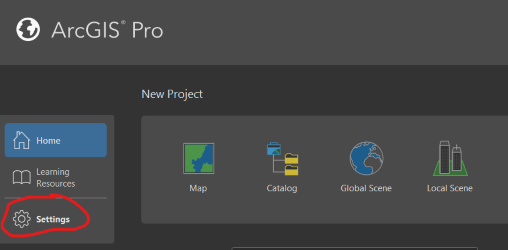

Jupyter Notebooks are implemented in ArcGIS Pro, you can create a new notebook, add an existing one, edit and run it. Go to Package manager and type "jupyter" in the search bar. You'll see that the ArcGIS Pro Python environment contains all Jupyter packages including ```ipykernel``` which you needed to install into the conda environment.

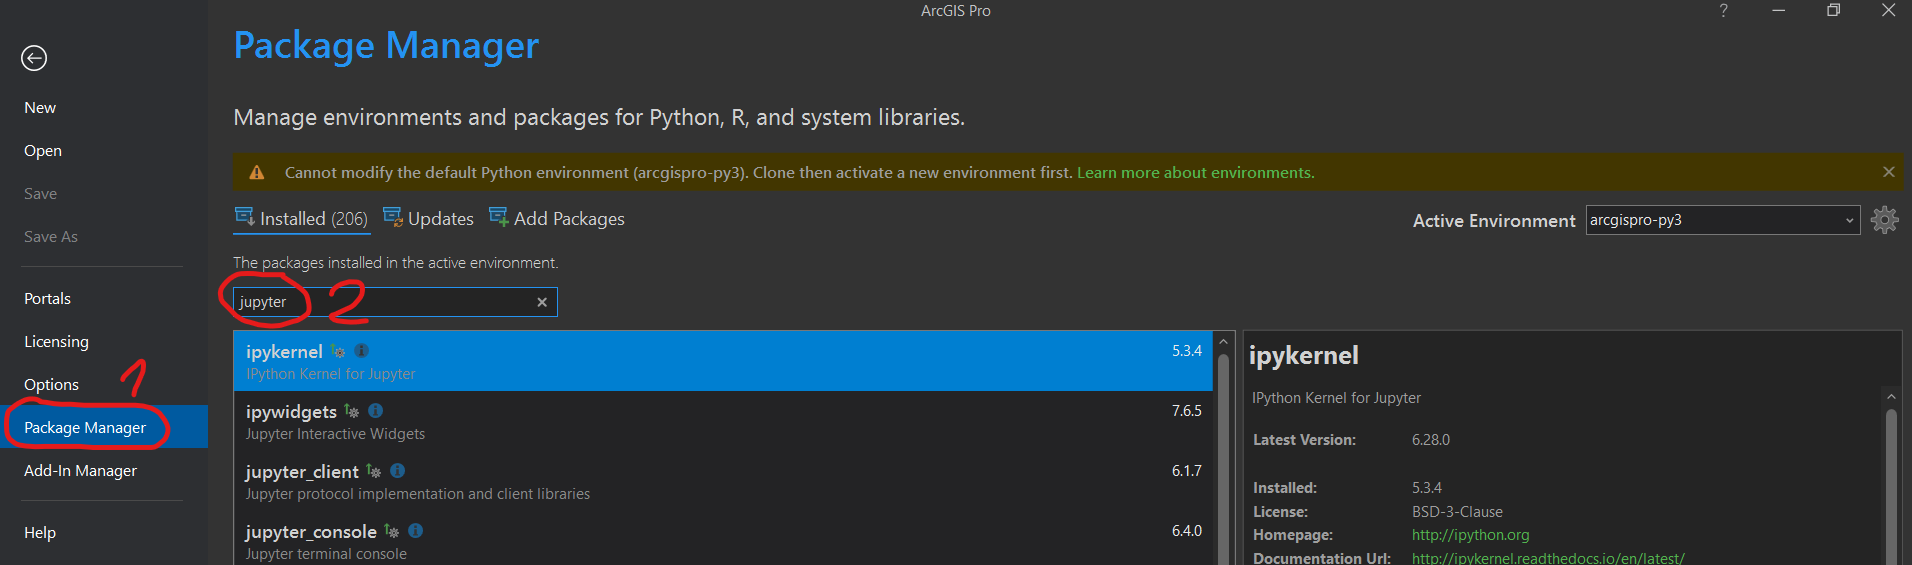

If you want to work with notebooks in ArcGIS Pro and you don't need some other packages that are not installed in this default environment, you can just jump straight into it.

In case you want to use this Python environment outside of ArcGIS Pro or you want to use some other Python packages, you need to clone this default environment. The screenshot instructions below show how to do it.

1. Click on "environment manager".

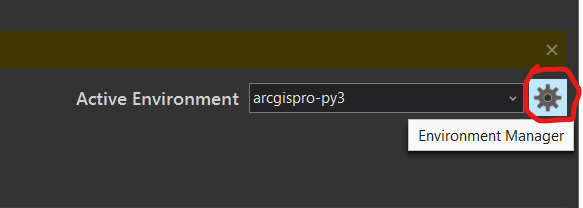

2. Click on "clone environment".

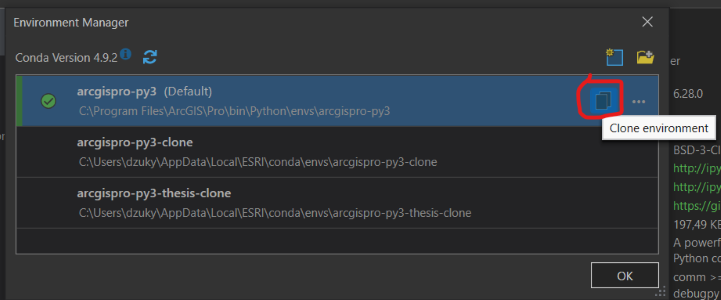

3. Name the clone and press OK. Cloning will take a few minutes.

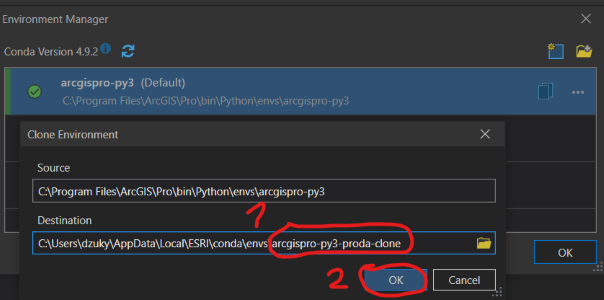

4. Activate it.

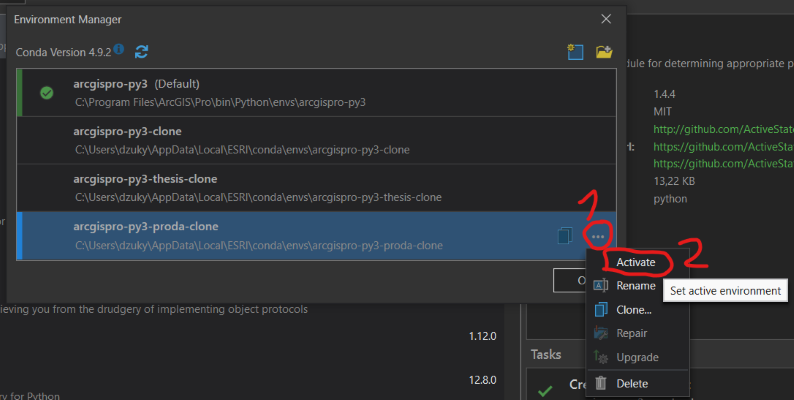

5. After the activation click on OK button to close the environment manager. Now you are able to install Python packages into this cloned environment. You can do that using Add Packages tab in the Package manager or cmd or terminal in VS Code.

Create a new ArcGIS Pro project, but not in the github cloned folder.

## How to work with Jupyter Notebooks using ArcGIS Python environment in VS Code <a id="outside"></a>

Now when you have your ArcGIS Python environment ready, select it as a kernel and start coding.

1. Import ```arcpy``` package, set your project's .gdb as a workspace and allow overwriting outputs with the same name.

2. Save the path to ```"ArcCR33/AdministratiniClenenie_v13.gdb/"```. Then [export](https://pro.arcgis.com/en/pro-app/latest/tool-reference/conversion/export-features.htm) the Lutín municipality from the layer ```"ObceBody"``` into a new layer in the workspace .gdb. Go to your ArcGIS project and check the .gdb whether the exported point layer is there. Or you can do that using [ListFeatureClasses](https://pro.arcgis.com/en/pro-app/latest/arcpy/functions/listfeatureclasses.htm) method.

3. Create a 10 km [buffer](https://pro.arcgis.com/en/pro-app/latest/tool-reference/analysis/buffer.htm) around the exported Lutín municipality.

4. From ```"ArcCR33/ArcCR500_v33.gdb/"``` [clip](https://pro.arcgis.com/en/pro-app/latest/tool-reference/analysis/clip.htm) these layers: 
```"Lesy"```, ```"SidlaPlochy"```, ```"Silnice_2016"```, ```"VodniToky"```.
From ```"ArcCR33/AdministratiniClenenie_v13.gdb/"``` [clip](https://pro.arcgis.com/en/pro-app/latest/tool-reference/analysis/clip.htm) the layer ```"Obce - Polygony"```.

## How to work with Jupyter Notebooks in ArcGIS Pro <a id="inside"></a>

ArcPy functions can also be run in VS Code as you saw in the previous section. Now it's time to switch into ArcGIS Pro and try editing and running Jupyter Notebooks there. 

Go to your ArcGIS Pro project and add this notebook there by click "Add notebook" button located under the "Insert" tab.

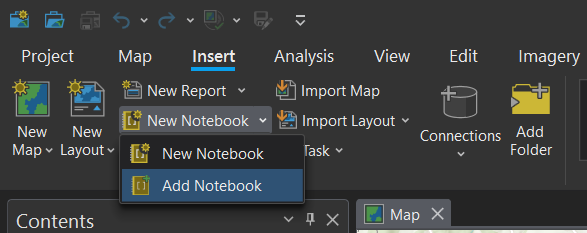

After the notebook is added, a new drop-down item named "Notebooks" is created in the catalog pane. Expand it and open the notebook either by double-clicking it or by choosing the "Open Notebook" option after a right-click on it.

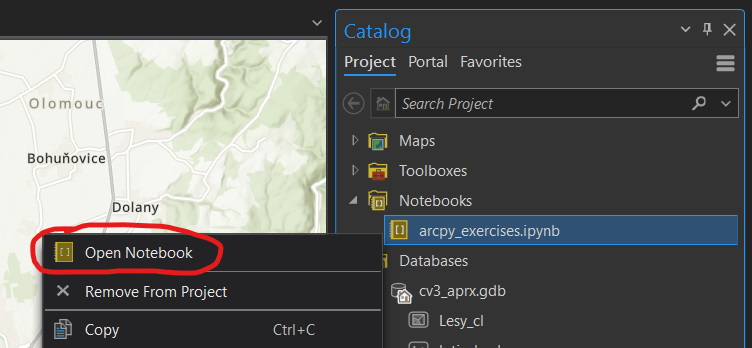

Continue now through this notebook in the ArcGIS Pro project. The notebook interface is a bit different from the VS Code notebook interface. 

Just run the first code cell with importing ```arcpy``` package, setting your project's .gdb as a workspace and allowing overwriting outputs with the same name, because it isn't saved in the notebook memory.

5. Print the shape type and the number of features for all clipped layers. You can use the [Get Count](https://pro.arcgis.com/en/pro-app/2.8/tool-reference/data-management/get-count.htm) tool and the [feature class properties](https://pro.arcgis.com/en/pro-app/latest/arcpy/functions/featureclass-properties.htm) of the Describe function.

6. Get the overall road length from the layer ```"Silnice_2016_cl"```. Print this length in km rounded to 2 decimal places. Use [Search Cursor](https://pro.arcgis.com/en/pro-app/latest/arcpy/data-access/searchcursor-class.htm) method.

7. Find the longest road in the same layer and print its length and OBJECTID.

8. Calculate the road density (*n* km of roads per 1 km2) in each clipped municipality (layer ```"ObcePolygony_cl"```) and write it in the new attribute field named ```"rd_density"```. 

Hint: use tools [Intersect](https://pro.arcgis.com/en/pro-app/latest/tool-reference/analysis/intersect.htm), [Dissolve](https://pro.arcgis.com/en/pro-app/latest/tool-reference/data-management/dissolve.htm), [Join Field](https://pro.arcgis.com/en/pro-app/latest/tool-reference/data-management/join-field.htm), [Add Field](https://pro.arcgis.com/en/pro-app/latest/tool-reference/data-management/add-field.htm), [Calculate Field](https://pro.arcgis.com/en/pro-app/latest/tool-reference/data-management/calculate-field.htm).

## Code cells folded

1.

In [ ]:
import arcpy
arcpy.env.workspace = r"D:\5.LS\PRODA\cv3_aprx\cv3_aprx.gdb"
arcpy.env.overwriteOutput = True
arcpy.env.workspace

2.

In [ ]:
arc_admin = "D:/ArcCR33/AdministrativniCleneni_v13.gdb/"
arcpy.conversion.ExportFeatures(arc_admin + "ObceBody", 
                                "lutin_point", "NAZ_OBEC = 'Lutín'")
arcpy.ListFeatureClasses()

3.

In [ ]:
arcpy.analysis.Buffer("lutin_point", "lutin_buffer", "10 Kilometers")
arcpy.ListFeatureClasses()

4.

In [ ]:
arc = "D:/ArcCR33/ArcCR500_v33.gdb/"
arc_layers = ["Lesy", "SidlaPlochy", "Silnice_2016", "VodniToky", "ObcePolygony"]

for i in arc_layers:
    if i == "ObcePolygony":
        arcpy.analysis.Clip(arc_admin + i, "lutin_buffer", i + "_cl")
    else:
        arcpy.analysis.Clip(arc + i, "lutin_buffer", i + "_cl")

arcpy.ListFeatureClasses()

5.

In [ ]:
for i in arcpy.ListFeatureClasses("*_cl"):
    feature_count =  arcpy.management.GetCount(i)
    desc = arcpy.Describe(i)

    print(i)
    print(f"number of features: {feature_count}")
    print(f"shape type: {desc.shapeType}")
    print(" ")
    

6.

In [ ]:
length = 0

with arcpy.da.SearchCursor("Silnice_2016_cl", ["OBJECTID", "SHAPE_Length"]) as cursor:
    for row in cursor:
        length += row[1]
        
print("overall road length is " + str(round((length/1000), 2)) + " km")

7.

In [ ]:
maxlength = 0
maxid = 0

with arcpy.da.SearchCursor("Silnice_2016_cl", ["OBJECTID", "SHAPE_Length"]) as cursor:
    for row in cursor:
        if row[1] > maxlength:
            maxlength = row[1]
            maxid = row[0]

print(f"the longest road's id is {maxid} and its length is {maxlength} m")

8.

In [ ]:
arcpy.analysis.Intersect(["Silnice_2016_cl", "ObcePolygony_cl"], "roads_isect", "ONLY_FID")
print("roads intersected")

In [ ]:
arcpy.management.Dissolve("roads_isect", "roads_isect_diss", "FID_ObcePolygony_cl")
print("intersected roads dissolved")

In [ ]:
arcpy.management.AddField("roads_isect_diss", "rd_length", "DOUBLE")
arcpy.management.CalculateField("roads_isect_diss", "rd_length", '!SHAPE_Length!')
print("roads length saved in a new field")

In [ ]:
arcpy.management.JoinField("ObcePolygony_cl", "OBJECTID", "roads_isect_diss", 
                           "FID_ObcePolygony_cl", ["rd_length"])
arcpy.management.AddField("ObcePolygony_cl", "rd_density", "DOUBLE")
arcpy.management.CalculateField("ObcePolygony_cl", "rd_density", 
                                '(!rd_length!/1000)/(!SHAPE_Area!/1000000)')
print("road density calculated")